# E10. Text Summarization
## 1. 데이터 및 패키지 불러오기

In [10]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [3]:
# 뉴스 기사 데이터
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
7838,Drones are no worse than cameraman: UK wildlif...,British wildlife photographer Will Burrard-Luc...
11276,Jaidev withdraws opposition to late father Bal...,"Jaidev Thackeray, the son of late Shiv Sena fo..."
41581,I-T Dept publicly names defaulters owing Ã¢ÂÂ...,The Income Tax Department has released a pan-I...
72350,"Ajay Devgn, Emraan Hashmi's 'Baadshaho' hits t...",The Ajay Devgn and Emraan Hashmi starrer 'Baad...
43658,'Padmaavat' earns Ã¢ÂÂ¹300 crore within 50 da...,"Deepika Padukone, Ranveer Singh and Shahid Kap..."
44939,"Lenin was a terrorist, why have his statue in ...",After a statue of Russian communist revolution...
24766,"'I am German when we win, an immigrant when we...","German midfielder Mesut ÃÂzil, who retired f..."
58697,NZ PM asks Ed Sheeran if he'll wear jandals fo...,New Zealand's PM Jacinda Ardern has sent Briti...
55610,What were the worst passwords of 2017?,According to password managing firm SplashData...
4765,"UP man wanted in 2015 case escapes from court,...","A man named Satish, against whom a non-bailabl..."


## 2. 데이터 전처리
### 2-1. 데이터 정리

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
# 불용어 개수 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [18]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

178.53968477249146  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [23]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [24]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-2. 훈련 데이터 및 테스트 데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


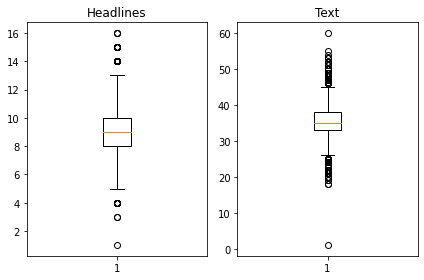

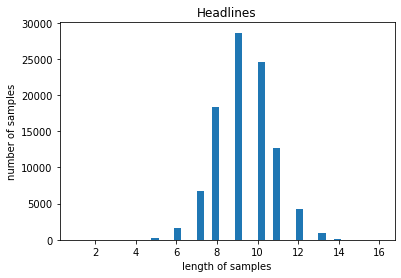

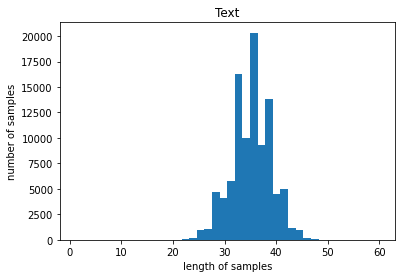

In [25]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
text_max_len = 50
headlines_max_len = 13

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [30]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [32]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data))) 

전체 샘플수 : 98166


In [33]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [34]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[10596  7506 64375 ... 50014 10014 27799]


In [37]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [38]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19633


In [39]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78533
훈련 레이블의 개수 : 78533
테스트 데이터의 개수 : 19633
테스트 레이블의 개수 : 19633


### 2-3. 정수 인코딩

In [40]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [41]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69656
등장 빈도가 6번 이하인 희귀 단어의 수: 47469
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22187
단어 집합에서 희귀 단어의 비율: 68.14775468014241
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.48924489907717


In [42]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[176, 621, 8956, 19428, 20672, 336, 32, 167, 2226, 942, 548, 69, 1, 424, 511, 815, 257, 533, 1, 23, 34, 1652, 19428, 2400, 40, 563, 1396, 19428, 6, 2008, 975, 621, 167, 1105, 927, 48, 494, 313, 7344, 32], [596, 967, 137, 12569, 1736, 118, 230, 13753, 1635, 20673, 11879, 7749, 95, 12569, 16, 10492, 4, 12569, 8510, 2209, 9446, 13754, 20674, 338, 1603, 13753, 20673, 2700, 416, 662, 12966, 13755, 8120, 11553], [3, 13, 37, 90, 84, 55, 4012, 608, 1292, 4981, 146, 37, 3090, 1719, 145, 225, 625, 11554, 1852, 66, 5542, 1056, 8, 45, 97, 39, 53, 4146, 1818, 66, 2015, 5982, 5032, 4577, 999, 8, 1]]


In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29987
등장 빈도가 5번 이하인 희귀 단어의 수: 19563
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10424
단어 집합에서 희귀 단어의 비율: 65.23826991696401
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.643586285403185


In [46]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 355, 3787, 3, 450, 802, 265, 3, 36, 351, 563], [1, 1686, 990, 9499, 374, 242, 6, 7672, 4, 79, 7213], [1, 20, 299, 510, 4, 1458, 5, 2844, 852, 20, 4, 921], [1, 671, 7214, 990, 1418, 5409, 52, 340, 1587, 1219], [1, 362, 1439, 36, 1220, 1712, 4411, 17, 3478]]
target
decoder  [[355, 3787, 3, 450, 802, 265, 3, 36, 351, 563, 2], [1686, 990, 9499, 374, 242, 6, 7672, 4, 79, 7213, 2], [20, 299, 510, 4, 1458, 5, 2844, 852, 20, 4, 921, 2], [671, 7214, 990, 1418, 5409, 52, 340, 1587, 1219, 2], [362, 1439, 36, 1220, 1712, 4411, 17, 3478, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78533
훈련 레이블의 개수 : 78533
테스트 데이터의 개수 : 19633
테스트 레이블의 개수 : 19633


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [48]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 3. 모델 설계

In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [50]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [51]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [52]:
# 어텐션 메커니즘
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [53]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 4. 모델 훈련

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 249s 774ms/step - loss: 5.6229 - val_loss: 4.8202
Epoch 2/50
307/307 [==============================] - 238s 776ms/step - loss: 4.7538 - val_loss: 4.4440
Epoch 3/50
307/307 [==============================] - 240s 781ms/step - loss: 4.3963 - val_loss: 4.1947
Epoch 4/50
307/307 [==============================] - 240s 781ms/step - loss: 4.1215 - val_loss: 4.0143
Epoch 5/50
307/307 [==============================] - 239s 778ms/step - loss: 3.9187 - val_loss: 3.8813
Epoch 6/50
307/307 [==============================] - 239s 779ms/step - loss: 3.7427 - val_loss: 3.7733
Epoch 7/50
307/307 [==============================] - 239s 779ms/step - loss: 3.6093 - val_loss: 3.6965
Epoch 8/50
307/307 [==============================] - 240s 780ms/step - loss: 3.4846 - val_loss: 3.6178
Epoch 9/50
307/307 [==============================] - 239s 778ms/step - loss: 3.3736 - val_loss: 3.5597
Epoch 10/50
307/307 [==============================] - 240s 781m

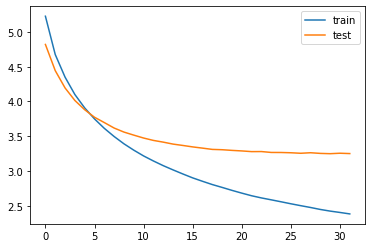

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5. 인퍼런스 모델 구현

In [6]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer .word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

NameError: name 'src_tokenizer' is not defined

In [57]:
 # 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [58]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [59]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 6. 모델 테스트

In [60]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [62]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : woman uk arrested suspicion murdering month old baby died falling sixth floor window police investigations launched alleged homicide year old woman due appear court wednesday 
실제 요약 : uk woman held for murder after toddler falls from th floor 
예측 요약 :  uk woman arrested for raping year old girl in month


원문 : police filed fir unknown lawyers banner comparing parliament attack convict afzal guru separatist leader bhat freedom fighters bhagat singh banner put srinagar court anniversary guru hanging hailed bhat heroes kashmir 
실제 요약 : fir filed for banner guru to bhagat singh 
예측 요약 :  fir against pak for pro pro khalistan event in punjab


원문 : telangana rashtra samithi celebrated president telangana caretaker chief minister chandrashekar rao election victory kg cake headquarters cake features car election symbol trs chandrashekar rao constituency votes 
실제 요약 : telangana cm kcr election victory celebrated with kg cake 
예측 요약 :  telangana deputy cm rao wins his th birthday


원문 : i

예측 요약 :  tripura govt bans dress code for wearing jeans


원문 : one body recovered south kolkata part majerhat bridge collapsed tuesday taking death toll two body suspected one two labourers missing since bridge collapsed police said probing incident angles west bengal cm mamata banerjee said 
실제 요약 : second body recovered from kolkata bridge collapse site 
예측 요약 :  bridge collapse bridge collapse in kolkata bridge collapse


원문 : america cry reunited childhood friend years twitter hey twitter met girl dinner cruise hawaii need help find tweeted posted picture heard looking friend replied within hours 
실제 요약 : childhood find each other after yrs through twitter 
예측 요약 :  girl claims he is victim of kid who is kid


원문 : american singer songwriter john legend performed jamaican singer bob song nobel peace prize award ceremony held sunday norway international campaign abolish nuclear weapons awarded nobel peace prize year earlier grammy award winning singer also performed nobel peace priz

예측 요약 :  rahul pilot win pilot hockey pilot in chhattisgarh cm


원문 : russian authorities stopped mexican football fans currently visiting country fifa world cup holding day dead themed parade moscow red square opposition lawmakers opposed dressing people skeletons parade held honour dead loved ones tomb soviet founder vladimir lenin situated square 
실제 요약 : russia stops mexican fans from holding day of dead parade 
예측 요약 :  russian fans stop russian wc team during match


원문 : reacting sun stopping play first new zealand india odi around minutes mayor bill said players need cricket outdoor sport bit weird wonder india go field sun eyes added 
실제 요약 : players must up mayor on break in odi 
예측 요약 :  india will not be used to play in india cricket world cup


원문 : trailer nawazuddin siddiqui starrer manto released actor portrays saadat hasan manto pakistani playwright author born british india film directed nandita das film premiered year cannes film festival scheduled release september 

## 7. 추출적 요약

In [8]:
# 라이브러리 불러오기
from summa.summarizer import summarize
from tqdm import tqdm

In [17]:
news_df = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1').text
news_df = news_df[0:5000]
mystr = ''
for i in tqdm(range(len(news_df))):
    mystr += str(news_df[i]) + '\n'

100%|██████████| 5000/5000 [00:00<00:00, 235017.15it/s]


In [18]:
with open('news_df.txt', 'w', encoding='utf-8') as f:
    f.write(mystr)

In [19]:
r = open('news_df.txt', mode='r', encoding='utf-8')
r = r.readlines()
r = r[0:50] # 50개만 진행해본다
r

["Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.\n",
 "Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.\n",
 "New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. Th

In [20]:
for i in r:
    print('Summary:')
    print(summarize(i, words=30) + '\n')

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

Summary:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series.
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

Summary:
Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.

Summary:
Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo moveme